In [1]:
!pip install opendatasets

In [3]:
import opendatasets as od

od.download('https://www.kaggle.com/paramaggarwal/fashion-product-images-small')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: bayuajinurmansah
Your Kaggle Key: ··········


  0%|          | 0.00/565M [00:00<?, ?B/s]

100%|██████████| 565M/565M [00:11<00:00, 49.8MB/s]


In [93]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

<h4>Open and preprocessing csv dataset </h4>

In [91]:
#read the csv file
df = pd.read_csv('/content/fashion-product-images-small/styles.csv', error_bad_lines=False , nrows=10000 , usecols=['id','masterCategory'])
df.head()

,id,masterCategory
0,15970,Apparel
1,39386,Apparel
2,59263,Accessories
3,21379,Apparel
4,53759,Apparel


In [97]:
df.masterCategory.value_counts()

Apparel           4831
Accessories       2534
Footwear          2073
Personal Care      535
Free Items          24
Sporting Goods       3
Name: masterCategory, dtype: int64

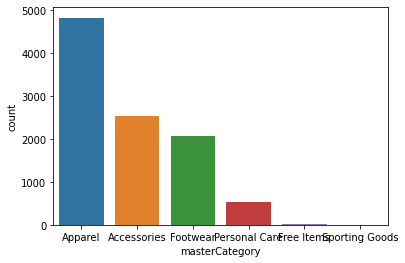

In [96]:
sns.countplot(x=df.masterCategory)
plt.show()

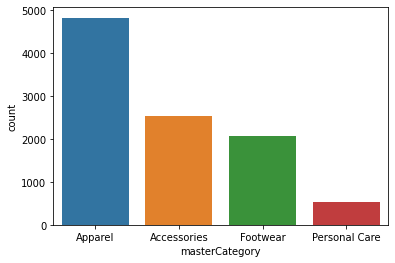

In [103]:
#hapus data free dan sporting goods

new_df = df[df['masterCategory'] !='Free Items']
new_df = new_df[new_df['masterCategory'] !='Sporting Goods']

sns.countplot(x=new_df.masterCategory)
plt.show()

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              10000 non-null  int64 
 1   masterCategory  10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [110]:
#add .jpg to column id , because id number get from images name

new_df['image'] = new_df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
new_df = new_df.sample(frac=1).reset_index(drop=True)
new_df.head()

,id,masterCategory,image
0,44266,Accessories,44266.jpg
1,2391,Footwear,2391.jpg
2,7736,Accessories,7736.jpg
3,57277,Apparel,57277.jpg
4,10186,Apparel,10186.jpg


<h4> Preprocess images using ImageDataGenerator </h4>

In [208]:
from keras_preprocessing.image import ImageDataGenerator

path = '/content/fashion-product-images-small/'

image_generator = ImageDataGenerator(
    validation_split=0.2,
)

train_generator = image_generator.flow_from_dataframe(
    dataframe=new_df,
    directory=path + "images",
    x_col="image",
    y_col="masterCategory",
    target_size=(96,96),
    batch_size=16,
    subset="training",
    class_mode ="categorical",
    color_mode="rgb"
)

validation_generator = image_generator.flow_from_dataframe(
    dataframe=new_df,
    directory=path + "images",
    x_col="image",
    y_col="masterCategory",
    target_size=(96,96),
    batch_size=16,
    subset="validation",
    class_mode="categorical",
    color_mode="rgb"
)

Found 7978 validated image filenames belonging to 4 classes.
Found 1994 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [209]:
#count how many classes that we have
classes = len(train_generator.class_indices)
print(classes)

4


In [244]:
from keras.applications.mobilenet_v2 import MobileNetV2

tf.keras.backend.clear_session()

tf.random.set_seed(42)

model = tf.keras.Sequential([
      MobileNetV2(weights = "imagenet", include_top = False ,input_shape=(96,96,3)),
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(1024, activation='relu'),
      tf.keras.layers.Dense(classes, activation='softmax')
  ])

model.layers[0].trainable = False



<h4> Callbacks </h4>

In [245]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.90 and logs.get('val_accuracy')>=0.90):
      print("\nAkurasi telah mencapai >=75%!")
      self.model.stop_training = True
callbacks_acc = myCallback()

callbacks_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1,
                                                    patience=10, min_lr=1e-5)

In [246]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
  )


In [247]:
history = model.fit(
    train_generator, 
    steps_per_epoch = train_generator.n // 32,
    epochs = 2,
    validation_data=validation_generator,
    callbacks = [callbacks_acc, callbacks_lr],
    verbose=2
)

Epoch 1/2
249/249 - 40s - loss: 0.3255 - accuracy: 0.8954 - val_loss: 0.3346 - val_accuracy: 0.8932
Epoch 2/2
249/249 - 36s - loss: 0.2071 - accuracy: 0.9274 - val_loss: 0.2305 - val_accuracy: 0.9253

Akurasi telah mencapai >=75%!


<h4> Prediksi gambar </h4>

Saving t2.jpg to t2.jpg
Personal Care


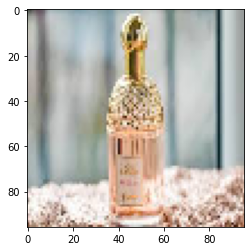

In [250]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# predicting images

uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(96,96))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  result = np.argmax(model.predict(images, batch_size=10))
  

  if result==0:
    print('Accessories')
  elif result==1:
    print('Apparel')
  elif result==2:
    print('Footwear')
  else:
    print('Personal Care')
